In [29]:
# Cell 1: Robust loading + SAFE funding parsing (EDA-ready)

import json
import pandas as pd
import numpy as np
import re

# Load data
with open("founder_list.json", "r", encoding="utf-8") as f:
    raw = json.load(f)

# Keep only valid dict rows
df = pd.DataFrame([r for r in raw if isinstance(r, dict)])

# ---------- SAFE funding amount parser ----------
def parse_amount(x):
    if not isinstance(x, str):
        return np.nan

    x = x.lower().strip()

    # extract numbers safely
    nums = re.findall(r"\d+\.?\d*", x)
    if not nums:
        return np.nan

    value = float(nums[0])

    if "billion" in x or "bn" in x:
        return value * 1e9
    if "million" in x or "m" in x:
        return value * 1e6
    if "thousand" in x or "k" in x:
        return value * 1e3

    return value

# Apply parsing safely
df["funding_amount"] = df["past_funding"].apply(
    lambda x: parse_amount(x.get("amount")) if isinstance(x, dict) else np.nan
)

df["funding_round"] = df["past_funding"].apply(
    lambda x: x.get("round") if isinstance(x, dict) else None
)

df["funding_year"] = df["past_funding"].apply(
    lambda x: x.get("year") if isinstance(x, dict) else None
)

df.head()


,name,company,domain,past_funding,valuation,competitors,umbrella_companies,team,funding_amount,funding_round,funding_year
0,1upHealth,1upHealth,1uphealth.com,"{'round': 'seed', 'amount': '$1766148420.10494...",10000000,"[Fitbit, Apple Watch]",[Google Health],NaN,1.766148e+09,seed,2022.0
1,Aalto University,Aalto,aalto.com,"{'round': 'Seed funding', 'amount': '$1 millio...",10000000,"[University of Helsinki, TKK by Aalto]",[Aalto University spin-offs],NaN,1.000000e+06,Seed funding,2022.0
2,Bing,ActionIQ,actioniq.com,"{'round': 'Series A', 'amount': '$100 million'...",10000000,"[Google Search, Yahoo! Search]",[Microsoft Corporation],NaN,1.000000e+08,Series A,2000.0
3,Equinor and Shell,Adura Technologies,aduratechnologies.com,"{'round': 'Series A', 'amount': '$10 million',...",10000000,"[Chevron, ExxonMobil]",[Oilfield Technology],NaN,1.000000e+07,Series A,2022.0
4,Alec John Marsh,Advano,https://www.bing.com/ck/a?!&&p=d71bfad9b16ba66...,"{'round': '', 'amount': '', 'year': 2022}",0,[],[],NaN,NaN,,2022.0


In [30]:
upper_cap = df["funding_amount"].quantile(0.95)
df["funding_amount_capped"] = df["funding_amount"].clip(upper=upper_cap)


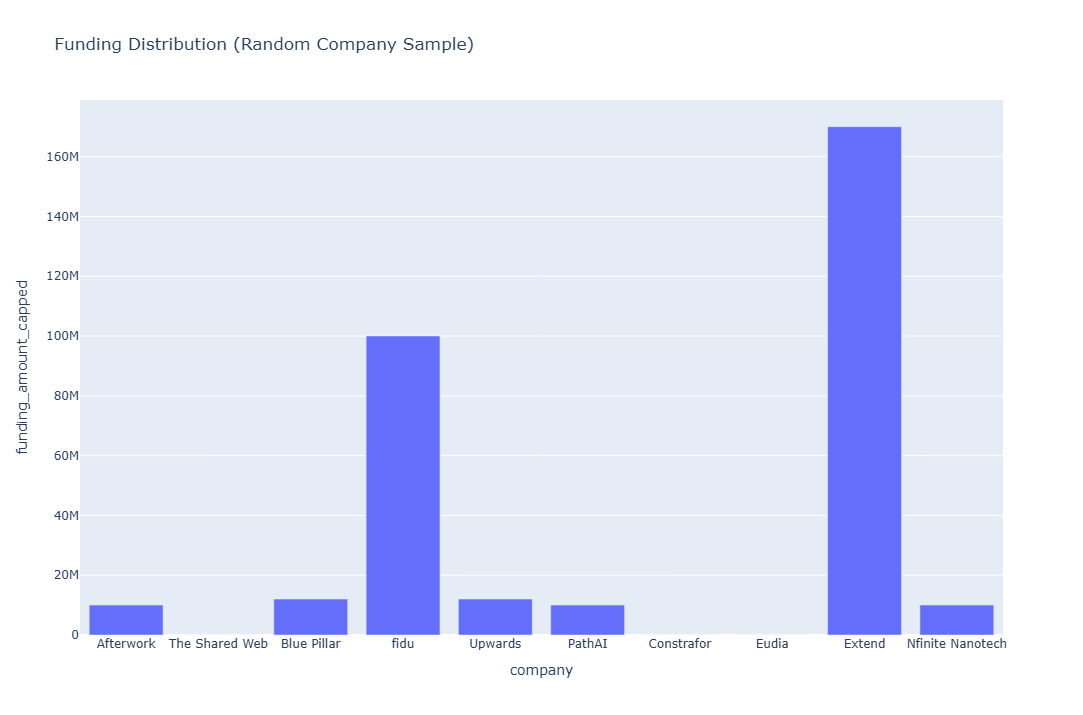

In [43]:
# Random 10 companies for visualization (avoids identical bars)

import numpy as np

# Drop rows without funding
valid_df = df.dropna(subset=["funding_amount_capped"])

# Randomly sample 10 unique companies
random_companies = (
    valid_df[["company", "funding_amount_capped"]]
    .drop_duplicates(subset=["company"])
    .sample(n=10, random_state=None)   # random every run
)

# Plot
import plotly.express as px

fig = px.bar(
    random_companies,
    x="company",
    y="funding_amount_capped",
    title="Funding Distribution (Random Company Sample)",
    width=1200,
    height=700

)

fig.show()


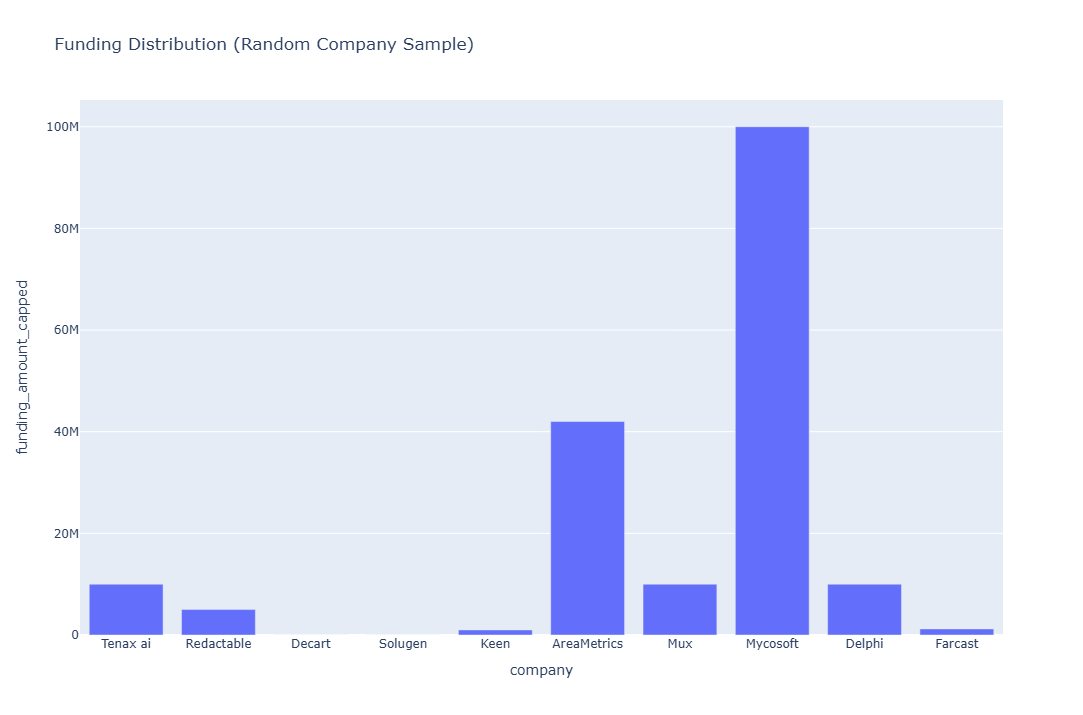

In [44]:
# Random 10 companies for visualization (avoids identical bars)

import numpy as np

# Drop rows without funding
valid_df = df.dropna(subset=["funding_amount_capped"])

# Randomly sample 10 unique companies
random_companies = (
    valid_df[["company", "funding_amount_capped"]]
    .drop_duplicates(subset=["company"])
    .sample(n=10, random_state=None)   # random every run
)

# Plot
import plotly.express as px

fig = px.bar(
    random_companies,
    x="company",
    y="funding_amount_capped",
    title="Funding Distribution (Random Company Sample)",
    width=1200,
    height=700

)

fig.show()


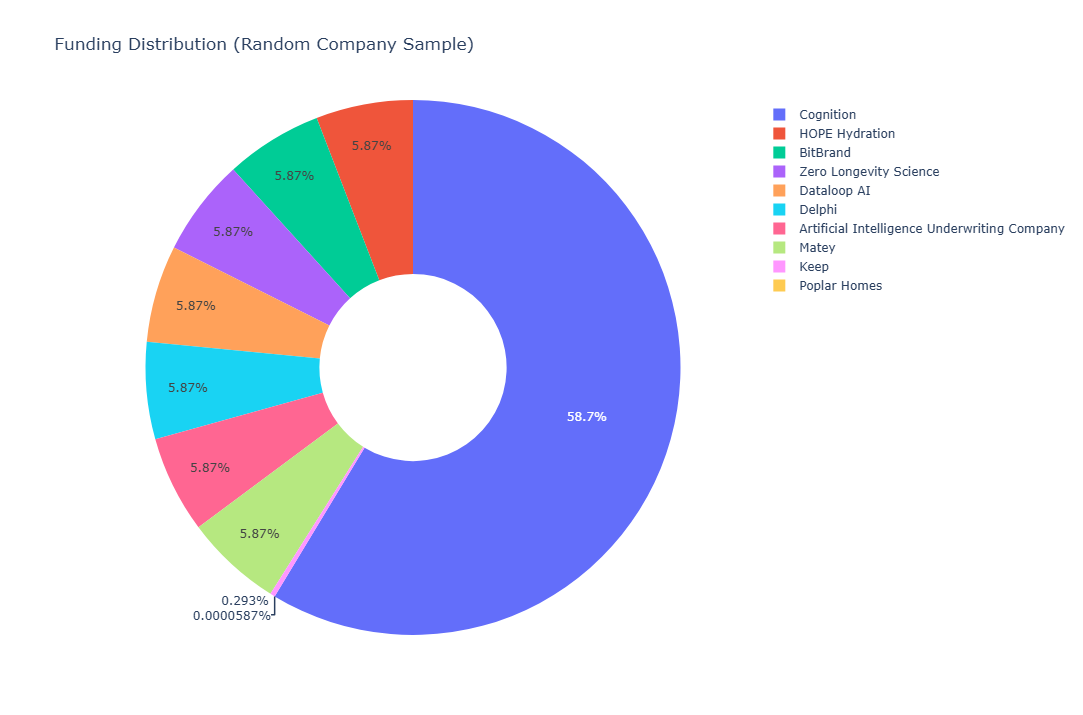

In [45]:
# Pie chart: Random company funding distribution

import plotly.express as px

# Keep only rows with valid capped funding
valid_df = df.dropna(subset=["funding_amount_capped"])

# Randomly select 10 unique companies
sample_df = (
    valid_df[["company", "funding_amount_capped"]]
    .drop_duplicates(subset=["company"])
    .sample(n=10)
)

fig = px.pie(
    sample_df,
    names="company",
    values="funding_amount_capped",
    title="Funding Distribution (Random Company Sample)",
    hole=0.35,
    width=1200,
    height=700

)

fig.show()


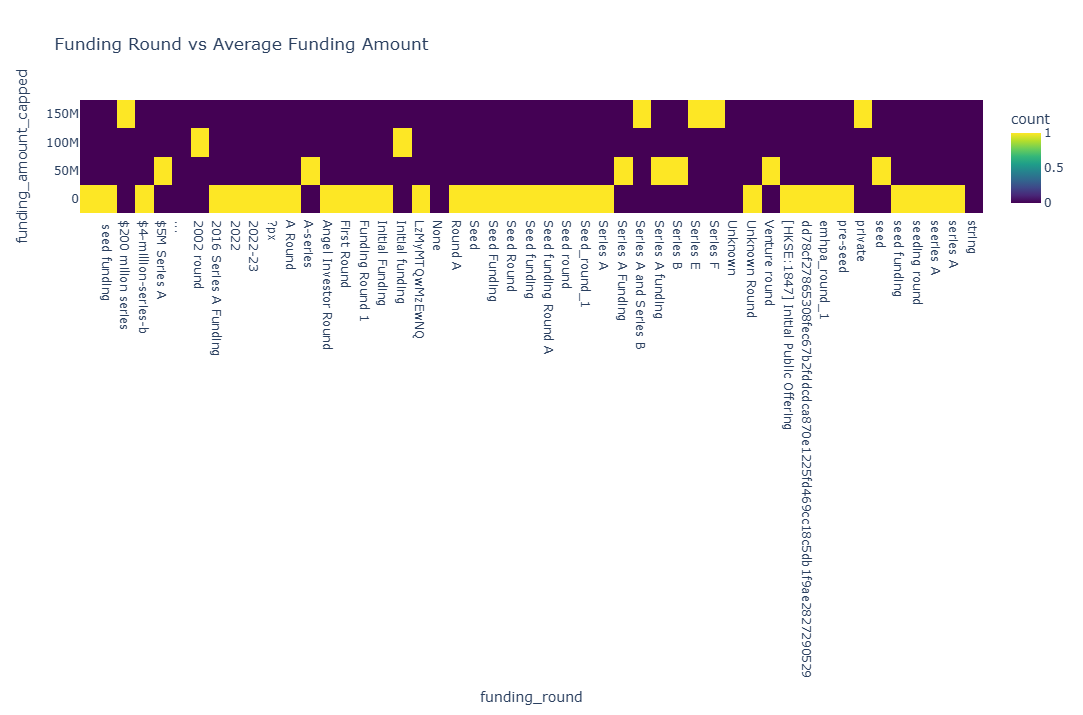

In [46]:
heat = (
    df.groupby("funding_round")["funding_amount_capped"]
    .mean()
    .reset_index()
)

fig = px.density_heatmap(
    heat,
    x="funding_round",
    y="funding_amount_capped",
    title="Funding Round vs Average Funding Amount",
    color_continuous_scale="Viridis",
    width=1200,
    height=700
)
fig.show()


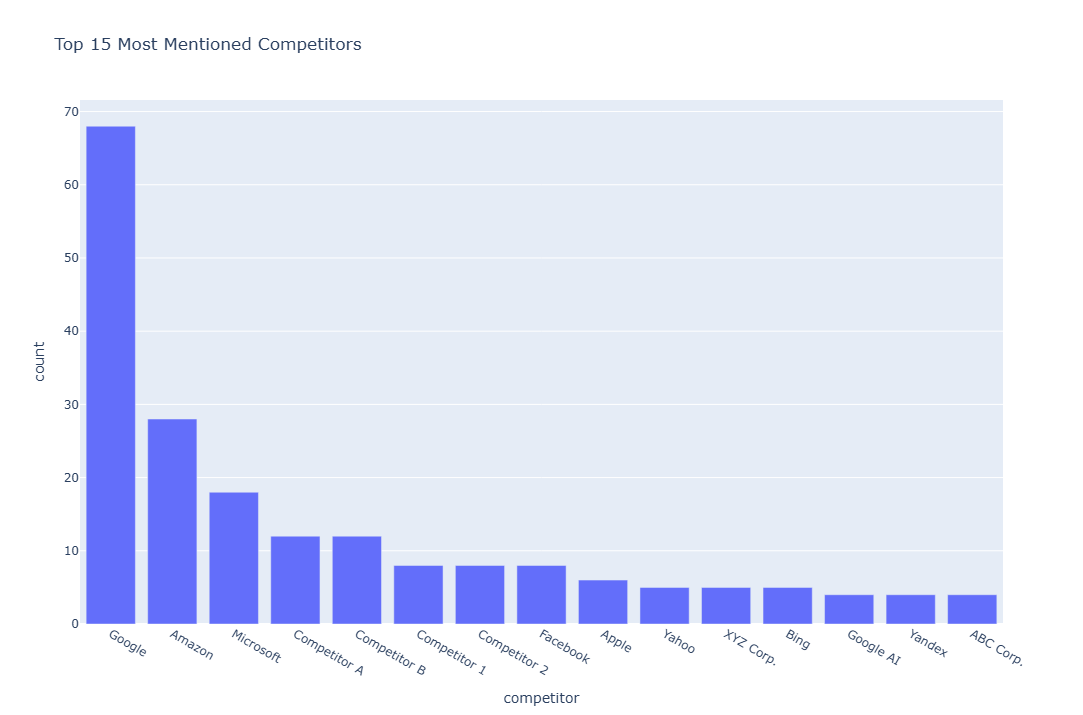

In [47]:
from collections import Counter

competitors = []
for c in df["competitors"]:
    if isinstance(c, list):
        competitors.extend([x.strip() for x in c if x.strip()])

comp_df = (
    pd.DataFrame(Counter(competitors).most_common(15),
                 columns=["competitor", "count"])
)

fig = px.bar(
    comp_df,
    x="competitor",
    y="count",
    title="Top 15 Most Mentioned Competitors",
    width=1200,
    height=700
)
fig.show()


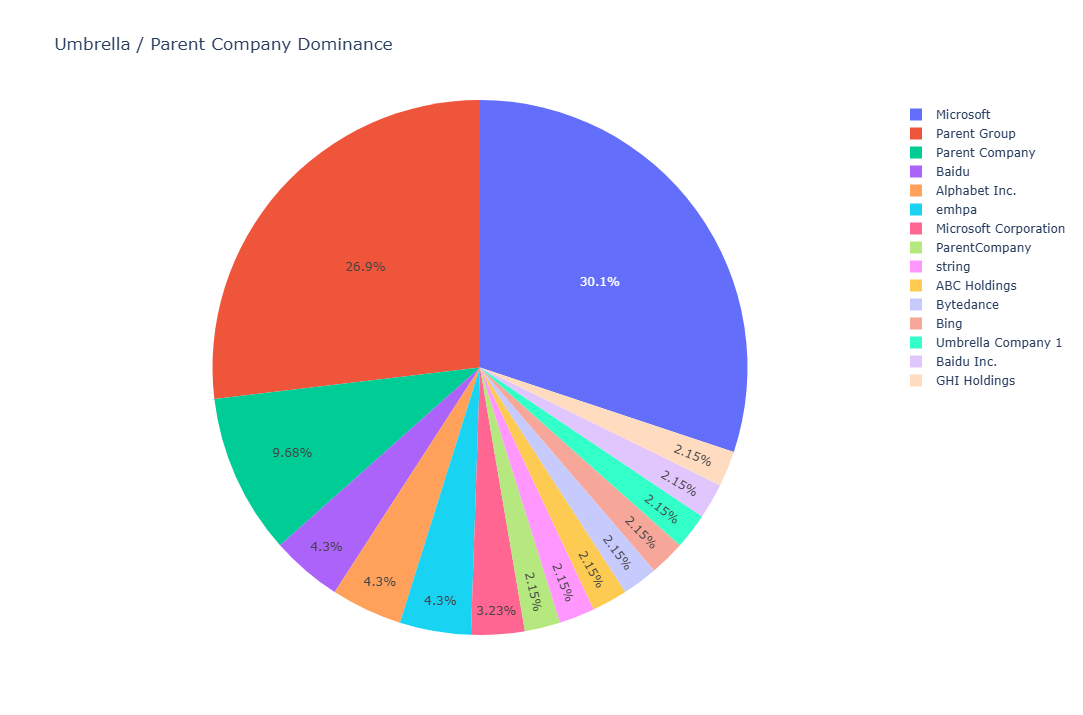

In [48]:
parents = []
for u in df["umbrella_companies"]:
    if isinstance(u, list):
        parents.extend([x.strip() for x in u if x.strip()])

parent_df = (
    pd.DataFrame(Counter(parents).most_common(15),
                 columns=["umbrella_company", "count"])
)

fig = px.pie(
    parent_df,
    names="umbrella_company",
    values="count",
    title="Umbrella / Parent Company Dominance",
    width=1200,
    height=700
)
fig.show()


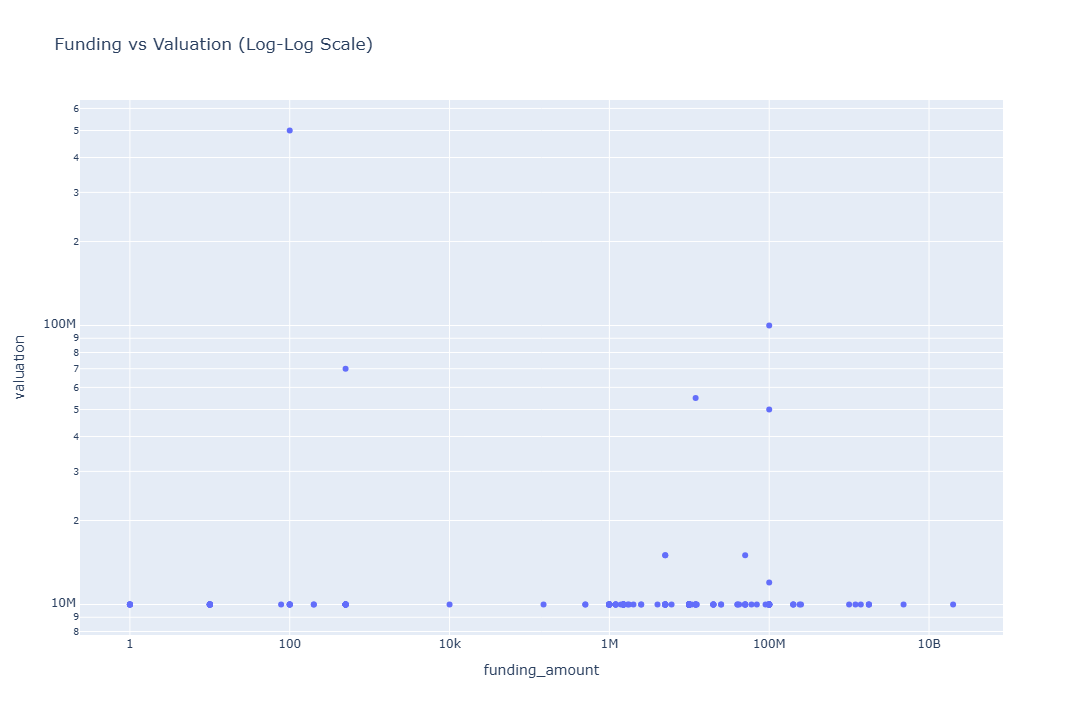

In [49]:
fig = px.scatter(
    df,
    x="funding_amount",
    y="valuation",
    log_x=True,
    log_y=True,
    hover_data=["company"],
    title="Funding vs Valuation (Log-Log Scale)",
    width=1200,
    height=700
)
fig.show()


In [37]:
exceptions = df[
    (df["funding_amount"].isna()) |
    (df["domain"].str.contains("bing.com", na=False)) |
    (df["domain"].str.len() < 4)
]

exceptions[["company", "domain", "past_funding"]].head(10)


,company,domain,past_funding
4,Advano,https://www.bing.com/ck/a?!&&p=d71bfad9b16ba66...,"{'round': '', 'amount': '', 'year': 2022}"
13,Approximate Labs,https://www.bing.com/ck/a?!&&p=5a49f1f7dff6c5b...,"{'round': 'Series A', 'amount': '$100M', 'year..."
16,Ark Biotech,https://www.bing.com/ck/a?!&&p=7346259af99bde2...,"{'round': 'pre-seed', 'amount': '20000000', 'y..."
22,Awell Health,autocompany.com,"{'round': None, 'amount': None, 'year': 2022}"
23,Azteco,https://www.bing.com/,"{'round': 'Seed funding', 'amount': '$10 milli..."
29,BitBrand,.co,"{'round': 'Series A', 'amount': '$10M', 'year'..."
30,Bitmine Immersion Technologies,https://www.bing.com/ck/a?!&&p=bf0bd0cd4367a88...,"{'round': 'Series A', 'amount': '$10 million',..."
32,Blue Pillar,https://www.bing.com/ck/a?!&&p=89808fc0ac553ae...,"{'round': 'Series A', 'amount': '$12 million',..."
39,Butler,https://www.bing.com/ck/a?!&&p=5b5e35c0b5257e1...,"{'round': '', 'amount': '', 'year': 2022}"
42,Candid Health,https://www.bing.com/ck/a?!&&p=5a084b46d5282c5...,"{'round': 'string', 'amount': 'string', 'year'..."


In [38]:
{
    "total_companies": df["company"].nunique(),
    "missing_funding_pct": df["funding_amount"].isna().mean() * 100,
    "unique_competitors": len(set(competitors)),
    "unique_parents": len(set(parents)),
    "median_funding": df["funding_amount"].median()
}


{'total_companies': 278,
 'missing_funding_pct': np.float64(11.151079136690647),
 'unique_competitors': 280,
 'unique_parents': 202,
 'median_funding': np.float64(10000000.0)}

In [50]:
q1 = df["valuation"].quantile(0.25)
q3 = df["valuation"].quantile(0.75)
iqr = q3 - q1

outliers = df[
    (df["valuation"] < q1 - 1.5 * iqr) |
    (df["valuation"] > q3 + 1.5 * iqr)
]

outliers.shape


(11, 12)

In [51]:
df.groupby("company")["name"].nunique().sort_values(ascending=False).head(10)


company
venn                  1
1upHealth             1
Aalto                 1
ActionIQ              1
Adura Technologies    1
Advano                1
Viz                   1
Viva Care             1
Vitable Health        1
Videogo               1
Name: name, dtype: int64

In [52]:
df.to_csv("founder_list_eda_ready.csv", index=False)
